### Loading the Forensic category of BLINK

In [ ]:
# !pip install datasets

In [4]:
from datasets import load_dataset

dataset_name = 'BLINK-Benchmark/BLINK'
data = load_dataset(dataset_name, 'Forensic_Detection')

c:\Users\samyv\miniconda3\envs\assignment_pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# print(data['val'][0])
data_val = data['val']
print(data_val)
data_test = data['test']
# print(data_test)
print(data_val[0]["question"])
print(data_val[0]["sub_task"])
print(data_val[0]["image_1"])

#merge data_val and data_test  : NO we don't have GT for the test set
# from datasets import concatenate_datasets
# data_val = concatenate_datasets([data['val'], data['test']])

Dataset({
    features: ['idx', 'question', 'sub_task', 'image_1', 'image_2', 'image_3', 'image_4', 'choices', 'answer', 'prompt', 'explanation'],
    num_rows: 132
})
Which image is most likely to be a real photograph?
Forensic Detection
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x1F9F39E7880>


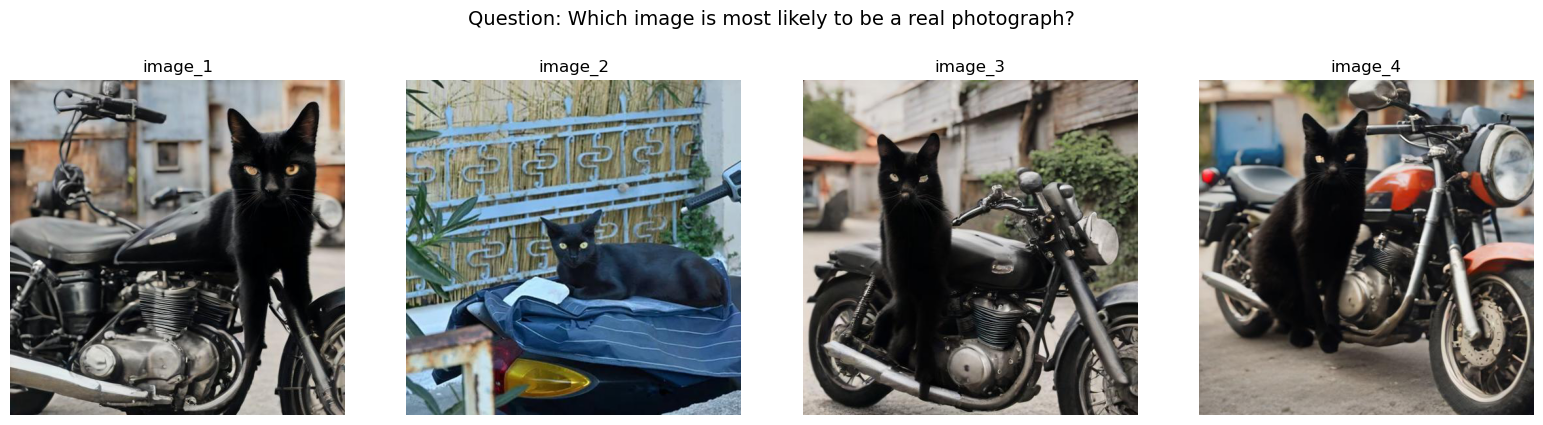

Prompt: You are a judge in a photography competition, and now you are given the four images. Please examine the details and tell which one of them is most likely to be a real photograph.
Select from the following choices.
(A) the first image
(B) the second image
(C) the third image
(D) the fourth image

Choices:
  A. the first image
  B. the second image
  C. the third image
  D. the fourth image

Correct Answer: (B)


In [ ]:
import matplotlib.pyplot as plt

def show_question_with_images(data, index):
    example = data[index]
    image_keys = ['image_1', 'image_2', 'image_3', 'image_4']
    
    images = [(key, example[key]) for key in image_keys if example[key] is not None]
    
    # display images in a row
    fig, axes = plt.subplots(1, len(images), figsize=(4 * len(images), 4))
    if len(images) == 1:
        axes = [axes]  
    for ax, (label, img) in zip(axes, images):
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    
    plt.suptitle(f"Question: {example['question']}", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

    # show choices and correct answer
    print("Prompt:", example["prompt"])
    print("Choices:")
    for i, choice in enumerate(example['choices']):
        print(f"  {chr(65 + i)}. {choice}")
    print("\nCorrect Answer:", example['answer'])

    if example.get('explanation'):
        print("\nExplanation:", example['explanation'])

show_question_with_images(data_val,4)


### Loading the DIRE model (specialist for forensic detection)

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from tqdm import tqdm
from utils.utils import get_network 

def evaluate_images_from_dataset(data, model_path, arch='resnet50', use_cpu=False, aug_norm=True): # this function is adapted from the demo.py file in the DIRE repository
    model = get_network(arch)
    state_dict = torch.load(model_path, map_location="cpu")
    if "model" in state_dict:
        state_dict = state_dict["model"]
    model.load_state_dict(state_dict)
    model.eval()
    if not use_cpu:
        model.cuda()

    print(f"Evaluating {len(data)} samples...")
    print("*" * 50)

    # Transform
    trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

    results = []

    for i in tqdm(range(len(data)), dynamic_ncols=True):
        for key in ['image_1', 'image_2', 'image_3', 'image_4']:
            img = data[i][key]
            if img is None:
                continue

            # Preprocess image
            img = trans(img)
            if aug_norm:
                img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            in_tens = img.unsqueeze(0)
            if not use_cpu:
                in_tens = in_tens.cuda()

            # Inference
            with torch.no_grad():
                prob = model(in_tens).sigmoid().item()

            results.append({
                "index": i,
                "image_key": key,
                "prob_synthetic": prob,
                "question": data[i]["question"],
                "answer": data[i]["answer"]
            })

    return results

results = evaluate_images_from_dataset(
    data_val, 
    model_path="./lsun_adm.pth", 
    arch="resnet50", 
    use_cpu=True, 
    aug_norm=True
)

#a  few predictions
for r in results[:12]:
    print(f"Index {r['index']} | {r['image_key']} | Synthetic prob: {r['prob_synthetic']:.4f}")


Evaluating 132 samples...
**************************************************


100%|██████████| 132/132 [00:48<00:00,  2.71it/s]

Index 0 | image_1 | Synthetic prob: 0.0032
Index 0 | image_2 | Synthetic prob: 0.0002
Index 0 | image_3 | Synthetic prob: 0.1942
Index 0 | image_4 | Synthetic prob: 0.0286
Index 1 | image_1 | Synthetic prob: 0.0098
Index 1 | image_2 | Synthetic prob: 0.0047
Index 1 | image_3 | Synthetic prob: 0.0036
Index 1 | image_4 | Synthetic prob: 0.0003
Index 2 | image_1 | Synthetic prob: 0.0099
Index 2 | image_2 | Synthetic prob: 0.2078
Index 2 | image_3 | Synthetic prob: 0.5407
Index 2 | image_4 | Synthetic prob: 0.2042


In [ ]:
letter_to_image = {
    "(A)": "image_1",
    "(B)": "image_2",
    "(C)": "image_3",
    "(D)": "image_4"
}
def normalize_answer(ans):
    ans = ans.strip().upper()
    if not ans.startswith("("):
        ans = f"({ans})"
    return letter_to_image.get(ans)

def compute_accuracy(results, data_val):
    from collections import defaultdict

    grouped = defaultdict(list)
    for r in results:
        grouped[r['index']].append(r)

    correct = 0
    total = 0

    for idx, preds in grouped.items():
        prompt = data_val[idx]['prompt'].lower()

        # determine whether to pick lowest or highest prob
        if "real" in prompt:
            best_pred = min(preds, key=lambda x: x['prob_synthetic'])
            # print(f"Index {idx} is a real image")
        else:
            best_pred = max(preds, key=lambda x: x['prob_synthetic'])

        predicted = best_pred['image_key']
        actual = data_val[idx]['answer']
        actual = normalize_answer(actual)


        if predicted != actual: # to inspect the wrong predictions
            print(f"\n Index {idx} | Predicted: {predicted} vs GT: {actual} | Prob: {best_pred['prob_synthetic']:.4f}")
            # print(f"Prompt: {data_val[idx]['prompt']}")
            # print("All image scores:")
            # for p in sorted(preds, key=lambda x: x['image_key']):
            #     mark = " <-- predicted" if p['image_key'] == predicted else ""
            #     print(f"  {p['image_key']}: {p['prob_synthetic']:.4f}{mark}")
        else:
            correct += 1
        total += 1

    accuracy = correct / total if total > 0 else 0
    print(f"\nAccuracy: {accuracy:.2%} ({correct}/{total})")
    return accuracy


compute_accuracy(results,data_val)


 Index 3 | Predicted: image_3 vs GT: image_2 | Prob: 0.0091

 Index 4 | Predicted: image_1 vs GT: image_2 | Prob: 0.0000

 Index 5 | Predicted: image_2 vs GT: image_4 | Prob: 0.0005

 Index 8 | Predicted: image_1 vs GT: image_4 | Prob: 0.0122

 Index 18 | Predicted: image_2 vs GT: image_4 | Prob: 0.0008

 Index 19 | Predicted: image_1 vs GT: image_4 | Prob: 0.0004

 Index 24 | Predicted: image_4 vs GT: image_1 | Prob: 0.0009

 Index 28 | Predicted: image_4 vs GT: image_1 | Prob: 0.3907

 Index 31 | Predicted: image_1 vs GT: image_3 | Prob: 0.0633

 Index 33 | Predicted: image_4 vs GT: image_2 | Prob: 0.0009

 Index 39 | Predicted: image_4 vs GT: image_3 | Prob: 0.0014

 Index 43 | Predicted: image_3 vs GT: image_1 | Prob: 0.0004

 Index 51 | Predicted: image_2 vs GT: image_1 | Prob: 0.0004

 Index 53 | Predicted: image_2 vs GT: image_3 | Prob: 0.0017

 Index 56 | Predicted: image_3 vs GT: image_4 | Prob: 0.0006

 Index 58 | Predicted: image_2 vs GT: image_4 | Prob: 0.0003

 Index 61 |

0.6893939393939394